# Solving MaxCut using the Quantum Approximate Optimization Algorithm (Cirq)

The Quantum Approximate Optimization Algorithm (QAOA) is a variational quantum algorithm which provides near-optimal solution(s) to combinatorial optimization problems (COP)s.

1. [What is a Combinatorial Optimization Problem?](#Combinatorial)  

2. [What is a Variational Algorithm?](#Variational)  

3. [MaxCut?](#MaxCut)  

4. [Modelling the Problem](#Model)  

5. [Physics of MaxCut - Ising Model](#Quantum)  

6. [QAOA and Cirq Code](#QAOA)

---

### What is a Combinatorial Optimization Problem? <a class="anchor" id="Combinatorial"></a>

A Combinatorial Optimization Problem is one which has finite or countably infinite solution set. As the size of the "inputs" to the problem grow, the set of possible solutions explodes in comparison. As mentioned in [this](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained) blog,  

" _Exponential means that the number of possible solutions typically depends on $a^n$ ($a$ is a constant depending on a problem and $n$ is the problem size). Combinatorial means that $n!$ is involved -- which is even worse than exponential_ "

When we say "optimize", it means we have a goal $-$ a function $-$ that attributes a value to a potential solution of the problem, taking into account the underlying system and its constraints. This value is like a success rating of the solution. We wish to find a solution that maximizes or minimises this goal function (also called cost function), depending on the problem.

The Qiskit textbook's section on [_Solving combinatorial optimization problems using QAOA_](https://qiskit.org/textbook/ch-applications/qaoa.html) lists a number of cases of minimization and maximization.  

* Minimize: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects.  

* Maximize: profit, value, output, return, yield, efficiency, capacity, number of objects.

Of course, adding a $(-)$ sign in front of the cost function switches a minimization problem into maximization and vice versa.

Some COP problems grow to such an extent that with the available resources, we can only hope to get an approximate solution, or near-optimal solution to a problem we are trying to solve. The algorithms that do this are hence called "Approximate optimization" algorithms.

### What is a Variational Algorithm? <a class="anchor" id="Variational"></a>

A variational algorithm is a term synonymously used with "hybrid quantum-classical algorithm". From the name, we infer that the algorithm involves certain classical components, and some quantum components. The term "variational" comes from the procedure in these algorithms of varying parameter values during execution in order to reach a desired optimal state. Usually, parameters are optimized classically. A quantum circuit with operators depending on those parameters is constructed, measurements (results) are obtained, based on which the parameters are tweaked, then the circuit is reconstructed with the updated parameters... and the cycle continues for a pre-defined number of steps. Such algorithms have been shown to provide good solutions, and are quite successfully used in partnership with the hardware capabilities of contemporary quantum computers.

QAOA is one of the popular variational algorithms, closely related to Variational Quantum Eigensolver ([VQE](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)). Other such algorithms include Quantum Neural Networks, and Variational Quantum Linear Solver.

### MaxCut? <a class="anchor" id="MaxCut"></a>

Simply stated, the MaxCut problem in graph theory is the following:  

Given a graph $G$ = $(V,E)$ where $V$ is the set of vertices and $E$ the set of edges, divide the set of vertices into 2 sets, such that the total number of edges crossing over from set to the other (meaning from points of one set to the points of the other) is maximized.  

In other words,  

Given a graph with vertices and edges, colour the each node in one of two colours, such that the number of edges between nodes of different colours is maximised, or as large as possible.  

In more words,  

Given some undirected graph $G$ = $(V,E)$, find the _cut_ that passes through $S\subset E$, such that $|S|$ is maximized. A cut is defined as a partition of the nodes of a graph into two subsets, $A$ and $B$ such that $A \cup B$ = $V$ and $A \cap B$ = $\phi$ (null set).

The simpler version of the problem contains unweighted edges, meaning a graph in which all the edges are equally "important". A more general version of the problem is with weighted edges, with the goal of partitioning the points to maximise the _total weight of edges_ between the two solution sets. In the weighted version, the number of edges need not be high, but the weight must be.

One of the points to notice here, which helps us in modelling the problem to solve it computationally is that points have to be partitioned in two sets only, i.e. there are only two colours. We can represent points belonging to the first subset using $0$ and the remaining/other points with $1$. So the possible divisions of the set $V$ are $2^n - 2$ in number (-2 to have proper subsets), where $n$ is the number of nodes. If we imagine a triangular graph with 3 nodes, labelled 1,2,3, there are $2^3 -2 = 6$  possible ways in which we can divide those 3 nodes into 2 sets with each set containing at least 1, but not all of the points. To explicitly state them, $001, 010, 011, 100, 101,$ and $110,$ with the index of each digit denoting the node it represents.

With just 3 nodes we have 6 possibilities, with $n$ = 4 we have 14, and with a 10-node graph, there are 1022 different divisions possible.

### Modelling the Problem <a class="anchor" id="Model"></a>

MaxCut is an optimization problem, so, we need a cost function to optimize. How can we build a function to capture the constraints of MaxCut?  

Let's denote our cost function with $\normalsize C(x)$, where $\normalsize x$ represents an edge. We want $\normalsize C(x)$ to have a higher magnitude when it encounters a higher number of edges with opposite colour nodes.

Let's say, in the case of an unweighted edge $\normalsize x$ between $\normalsize x_i$ and $\normalsize x_j$, we add $-1$ to the cost $\normalsize C$ when $\normalsize x_i$ and $\normalsize x_j$ belong to different vertex sets, and add $+1$ otherwise. The reason will become apparent in the next few lines. We now need to assign values to the possible configurations of $\normalsize x_i$ and $\normalsize x_j$ to make the $\pm1$ happen.  
We have vertices divided into 2 groups (denoted by 0 and 1 respectively). Let the value of $\normalsize x_i$ be -1 if it is in the $0$ group, and +1 if it is in the $1$ group.  

Let $\normalsize C(x) = x_i \times x_j$  

We can verify that this $\normalsize C(x)$ behaves like we expect.  

If $\normalsize x_i$ and $\normalsize x_j$ are both in 0, or both in 1, their product will be $(-1) \times (-1) = 1$ or $1 \times 1 = 1$.  

If $\normalsize x_i$ and $\normalsize x_j$ are both in 0, or both in 1, their product will be $(-1) \times 1 = -1$ or $1 \times (-1) = -1$.  

Hence we can now associate a value of 1 or -1 with every edge. The sum of these values can then become our cost function. Since the value associated with edges across the $0$ and $1$ groups are favourable to us, we ultimately want to have a sum that is as negative as possible. In other words, want to minimize the sum of all $C(x)$.  

$minimize \normalsize \sum_x C(x)$, where $x \in E$  

Or, alternatively, the problem can be converted into a maximization problem by inverting the sign of $C(x)$, by making one of the following changes:

* Redefine $C(x)$ as $\normalsize C(x) = - (x_i \times x_j)$ or  
* $\normalsize maximize \normalsize \sum_x -C(x)$  


**Note**  that we assign a value of $(-1)$ and $(+1)$ to nodes in the two groups, the product of which then increases or decreases the overall cost by $1$.  

<a class="anchor" id="nochange"></a>


**Note**
It will be useful to notice now that adding or (uniformly) multiplying positive constants will not change the goal of the cost function. As in, every arrangement will be equally affected, so there will not be any relative difference in doing so.  

### The Physics of MaxCut <a class="anchor" id="Quantum"></a>

The next step is the translation of the above cost function into the language of Physics. But before we get into that formulation, let us look at a few more concepts that will be needed later.

$\textbf{Ising Model}$

The Ising model is a mathematical model used to study the behaviour of particles as part of a larger system. The most common application of this is the study of magnetic properties of electrons interacting with other electrons. Under the Ising model, each electron is represented as a square in a grid/lattice, with each square assuming a value of $(+1)$ or $(-1)$, where $(+1)$ corresponds to an electron in upward spin ($\uparrow$) and $(-1)$ corresponds to downward spin ($\downarrow$).  

Each electron's spin gives it a small magnetic moment, which when combined with many other small moments in a system can generate macro properties of the entire system. The $(+1)$ and $(-1)$ of an electron's neighbours in the lattice can reinforce or diminish its moment. The Ising model representation makes it easier to study those interactions and the behaviour of the entire system.



Ising Model Visual


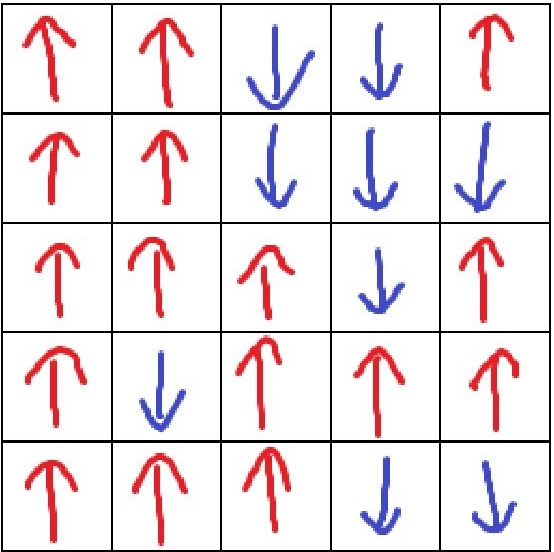

In [1]:
from IPython.display import Image
print("Ising Model Visual")
Image('ising.jpg', width=300, height=300)

Another application is the study of the behaviour of alloys, where each site in the lattice corresponds to an atom, and values are attributed to each cell based on what kind of atom is present there.

##### Ising models are relevant here since they prove to be useful in building the cost function we need for the MaxCut problem.

If we consider our input graph (for MaxCut) as a physical system, the cost function we constructed can be a proxy for the overall energy of that system. Each node of our graph can be a lattice site. Further, we can (as in the previous section) assign the values of $(+1)$ and $(-1)$ to the groups we partition our points into. In the goal function we constructed above, each $\normalsize x_i$ takes the values $(\pm 1)$ according to whether it belongs in group $0$ or group $1$.  
Minimizing (maximizing) the value of our cost function hence means that we want to minimize (maximize) the energy of the system defined by our graph.  

The energy of a system is defined by a _hamiltonian_. The following extract from _Quantum Computing for Computer Scientists_ by N. S. Yanofsky and M. A. Mannuci introduces the concept of a hawell:  

"_We can think of a physical system as specified by a double list: on the one hand, its state space, i.e. the collection of all the states it can possibly be found in, and on the other hand, the set of its *observables*, i.e., the physcial quantities that can be observed in each state of the statespace.  
Each observable may be thought of as a specific queastion we pose to the system: if the system is currently in some given state $|\psi\rangle$, which values can we possibly observe?_  

_In our quantum dictionary, we need to introduce the mathematical analog of an observable:_  
*$\small\textbf{Postulate 4.2.1}$* : To each physical observable there corresponds a hermitian operator.  

$...$  
_Energy is an observable, and therefore for a concrete quantum system, it is possible to write down a hermitian matrix representing it (this expression will of course vary from system to system). This observable is called the_ $hamiltonian$ _of the system._ "

> A hermitian matrix is a matrix that is equal to its complex conjugate. ($A = A^\dagger \implies$ A is hermitian)

The next logical question is, since we have a mathematical goal function that describes the energy of our graph system, how do we get the corresponding hamiltonian that describes the energy in the same terms?

The function $\normalsize C(x)$ that we have for each edge takes a value of $\pm1$ depending on the colouring of the nodes that it connects. We need a quantum _something_ that does the same; a quantum operator, that perhaps leaves the state unchanged except for a factor of $\pm1$. The Pauli-Z operator,

<div align="center">$\large \sigma^z = \begin{bmatrix}1 & 0 \\0 & -1\end{bmatrix}$</div>

does exactly that. It has eigenvalues of $+1$ and $-1$, which means that when it acts on a qubit, it "assigns" the qubit a value of  

$\normalsize+1$, i.e. $\normalsize (\sigma_z |0\rangle = 1\cdot|0\rangle)$, or  
$\normalsize-1$, i.e. $\normalsize (\sigma_z|1\rangle = -1\cdot |1\rangle)$

We need to tweak our cost function a little bit in order to be able to translate classical function to quantum.

We stated [earlier](#nochange) that the optimization goal remains the same if we add values or multiply positive constants to the cost function. So our cost function can be restated without loss of generality, as  

* $\normalsize C(x) = \large\frac{1}{2}\normalsize(x_i x_j - 1)$, with our goal being  

* $\normalsize minimize \sum_x C(x)$

With this, the quantum analog for our $\normalsize x_i$ and $\normalsize x_j$ is the Pauli-Z operator of nodes $i$ and $j$ repsectively. Substituting $\normalsize \sigma_i^z$ and $\normalsize \sigma_j^z$ for $\normalsize x_i$ and $\normalsize x_j$ respectively, we have our cost Hamiltonian $H_C$:

$\normalsize H_C = \sum_z \frac{1}{2}(\sigma_i^z \otimes \sigma_j^z - I)$ for each edge $\normalsize z$ between nodes $\normalsize i$ and $\normalsize j$,  

where $\normalsize I$ is the identity matrix.  

## Quantum Approximate Optimization Algorithm <a class="anchor" id="QAOA"></a>

Finally the fun begins. $\large Code$.

There are lots of code tutorials available online on blogs and softwarer libraries' websites, such as Qiskit, Pennylane, two on Google Quantum AI's website using Cirq and [this](https://lucaman99.github.io/new_blog/2020/mar16.html) blog.

For those familiar with Grover's algorithm, a single application of Grover's oracle "marks" the desired solution states out of an equal superposition of all states, and the diffusion operation enhances the probabilities of those marked states. QAOA uses two parametrized gates (with parameters optimized classically), which perform similar operations as marking and enhancing the states from the equal superposition. These gates in QAOA incorporate the cost Hamiltonian we created above, $H_C$. As in Grover's algorithm, increased number of iterations provide better results, so is the case here. Let us look at how this happens.

We will code as we go along constructing the circuit. The implementation in this notebook is using Cirq.

In [2]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import networkx as nx
from scipy.optimize import minimize

We construct a simple class to hold our Edges. Default weight of each edge is 1.0

In [3]:
class Edge:
    def __init__(self, start_node, end_node, weight=1.00):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight

Let us code a simple graph unweighted for algorithm demonstration, and then look at larger and weighted graphs later. We will use a straight line graph with 5 nodes, and 4 edges:

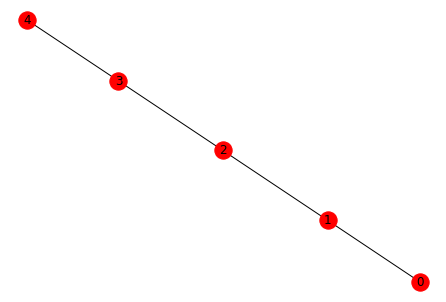

In [4]:
# set of edges, unweighted
set_edges = [Edge(0,1), Edge(1,2), Edge(2,3), Edge(3,4)]

# create the graph instance
G = nx.Graph()

# and add the edges to it
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight=edge.weight)

# print the graph
nx.draw(G, with_labels = True, node_color = 'r')

The [original paper](https://arxiv.org/abs/1411.4028) by Farhi et al. introduces the algorithm by defining the general form of an objective function, which is similar to our $C = \sum_xC(x)$.

To re-iterate, our cost Hamiltonian is  

<div align="center">$\large H_C = \sum_z (\sigma_i^z \otimes \sigma_j^z - I)$</div>

We define a unitary operator, that is diagonal in the computational basis (i.e all non-zero elements in the matrix representation lie on the principal diagonal), whose diagonal elements are all the possible values of the cost function. An additional parameter $\large\gamma \small \in [0,2\pi)$ is introduced, which decides the phases attached to each of the states in superposition:

<div align="center">$\large U(\gamma, H_C) = e^{-i\gamma H_C}$</div>  

We will call this the cost unitary. The cost unitary merely attaches complex amplitudes, but does not affect the probability of prediction. All the states are still in equal superposition.

This concept is part of [matrix exponentials](https://qiskit.org/textbook/ch-appendix/linear_algebra.html#Matrix-Exponentials), described in the Linear Algebra appendix in the Qiskit Textbook. Custom operators are built using this concept and those operators can then be included in circuits for variety of purposes. We use them here for QAOA.

In [5]:
# the function to attach a cost unitary to each edge with iput gamma value
def cost_unitary(gamma, qubits):
    for edge in set_edges:
        yield cirq.ZZ.on(qubits[edge.start_node],qubits[edge.end_node])**(gamma*edge.weight)

The next unitary operator is the part of the circuit that enhances the desired states (cost minimizing states). It is called the mixer unitary, constructed from a mixer hamiltonian  

<div align="center">$\large H_B = \sum_j \sigma_j^x$.</div>  

It is called a mixer Hamiltonian since it introduces non-diagonal elements into the diagonal matrix of $U(\gamma,H_C)$ by rotating the qubits in the Bloch sphere around the $x$-axis. Any mixer hamiltonian that does not commute with the cost Hamiltonian's components would suffice. This particular $H_B$ is most commonly used, hence we proceed with the same. Introducing non-diagonal elements implies superposition, which is something not possible in a classical setting.  


<div align="center">$\large U(\beta, H_B) = e^{-i\beta H_B}$, where $\normalsize \beta \in [0,\pi)$</div>

After the application of $U(\beta, H_B)$, constructive and destructive interference takes place, improving the amplitudes of the states that give small $C$ and diminishing/eliminating states with high C values.

In [6]:
# the function to apply the mixer unitary
def mixer_unitary(beta, qubits):
    for q in qubits:
        yield cirq.X(q)**beta

We have $U(\gamma, H_C)$ and $U(\beta, H_B)$. These two operators form one "iteration" of the algorithm. The more the number of times these are applied, in the same alternate fashion, the better our results will be. This "number of times" is denoted by $p$, and also referred to as depth of the circuit. It is proven that when $p\rightarrow\infty$, the solution state we achieve using QAOA is not approximate, but the true optimal value for our problem.

We mentioned in the small section on [variational algorithms](#Variational), that there are parameters in the circuit components to be optimized classically. In the present algorithm, $\normalsize \gamma$ and $\normalsize \beta$ are those parameters.  

There are multiple methods of optimizing the parameters.  

When the circuit is small and the graph's degree is bounded, the expectation value

<div align="center">$\normalsize F_p(\gamma, \beta) = \langle\normalsize\psi_p(\gamma,\beta)|H_C|\psi_p(\gamma,\beta)\rangle$</div>  

can be evaluated classically, and the values of $\gamma$ and $\beta$ that optimize our can be obtained.  

The other methods involve simulating the circuit/running the circuit on real hardware and sampling. The results sampling can then be used to evaluate the average cost over all the results and target the minimization of this average cost by varying the parameters. We can define a cost function that collects simulation results and passes it to an in-built minimization function (e.g. scipy.optimize), or iterate over a fine grid of the possible values of $\gamma$ and $\beta$ values and find out best parameters from the values of that grid.

We will use the simulation methods and figure out optimal $\large\gamma$ and $\large\beta$.

Let us make a function to create a circuit with `n` qubits with given input $\large\gamma$ (`gamma`) and $\large\beta$ (`beta`) values, and depth $\normalsize p$.

In [7]:
def make_circuit(n, gammas, betas, p):
    cirquit = cirq.Circuit()
    qubits = [cirq.GridQubit(0,i) for i in range(0,n)]
    for q in qubits:
        cirquit.append(cirq.H.on(q))
    # print(cirquit)
    
    for i in range(0,p):
        cirquit.append(cost_unitary(gammas[i], qubits))
        cirquit.append(mixer_unitary(betas[i], qubits))
    
    # adding measurement gates
    cirquit.append(cirq.measure(*qubits))

    return cirquit

A function to sample the input circuit `cirquit` `rep` times and return the list of results:

In [8]:
def get_results(n, cirquit, rep=1000):
    sim = cirq.Simulator()
    results = sim.run(cirquit, repetitions=rep)
    results = str(results).split("=")[1]
    results = results.split(", ")
    new_res = []
    
    for i in range(0,rep):
        hold = []
        for j in range(0, n):
            hold.append(int(results[j][i]))
        new_res.append(hold)
    
    return new_res

We now have to create the function that calculates the average cost over all the results, which will serve as the function we aim to minimize. The results that are returned from `get_results` are 0s and 1s, whereas in our cost function we need 1 and -1 respectively. To achieve that we use the function $f(x) = 1 - 2x$, which maps $0$ to $f(0) = 1$, and $1$ to $f(1) = -1$.  
In the following function, for each result that we got, which is a 5-digit binary number, we iterate over each edge in our graph's edges (`set_edges`) whether that division of nodes gives the edge opposite nodes or within the same group.

In [9]:
def get_cost(params):
    gammas = []
    betas = []
    for i in range(0, len(params), 2):
        gammas.append(params[i])
    for i in range(1, len(params), 2):
        betas.append(params[i])
    
    qaoa = make_circuit(num, gammas, betas, p)
    results = get_results(num, qaoa, reps)
    
    cost = 0.0
    for i in range(0,len(results)):
        for e in set_edges:
            cost += e.weight*0.5*((1-2*results[i][e.start_node])
                                  *(1-2*results[i][e.end_node])-1)
    
    cost = float(cost)/len(results)
    
    return cost

We define the parameters that go into the above and then run the optimization function `scipy.optimize.minimize` on `get_cost`

In [10]:
num = G.number_of_nodes()
p = 1
reps = 1000
init_params = [float(random.randint(0,314))/float(100) for i in range(0,2*p)] # [gamma, beta]
init_params

[2.87, 1.96]

In [11]:
out = minimize(get_cost, x0 = init_params, method = "COBYLA", options = {'maxiter':100})
optimal_params = out['x']

# optimal gammas and optimal betas
opti_gammas = []
opti_betas = []

for i in range(0, len(optimal_params), 2):
    opti_gammas.append(optimal_params[i])
for i in range(1, len(optimal_params), 2):
    opti_betas.append(optimal_params[i])

print(optimal_params)
print(opti_gammas)
print(opti_betas)

[1.69182053 0.25466722]
[1.6918205260397179]
[0.2546672196805807]


We now construct the circuit with our optimal parameters, simulate and obtain measurement results, and plot the results to find which bitstring shows the best partition. The following is the optimal circuit

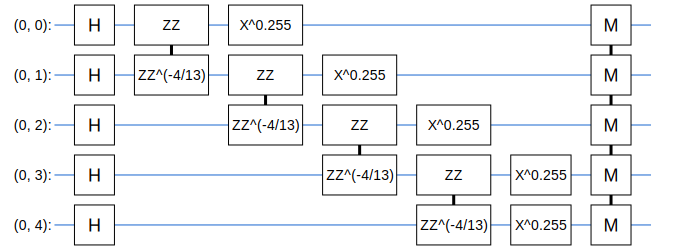

In [12]:
qaoa_opti = make_circuit(num, opti_gammas, opti_betas, p)
SVGCircuit(qaoa_opti)

In [13]:
reps = 10000
results = get_results(num, qaoa_opti, rep = reps)

# note the number denoted by the binary representation and its frequency
nums = []
freq = []

for i in range(0, len(results)):
    number = 0
    for j in range(0, len(results[i])):
        number += 2**(len(results[i])-j-1)*results[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

# divide the frequency by the total number of samples
freq = [f/reps for f in freq]

print(nums)
print(freq)

[21, 10, 13, 19, 14, 18, 25, 22, 9, 17, 11, 26, 15, 16, 20, 23, 12, 1, 4, 5, 27, 6, 31, 30, 28, 0, 29, 8, 24, 7, 3, 2]
[0.1704, 0.172, 0.0843, 0.0278, 0.0075, 0.0758, 0.0286, 0.0809, 0.0829, 0.008, 0.037, 0.036, 0.0066, 0.0061, 0.035, 0.0013, 0.0289, 0.0062, 0.0121, 0.0334, 0.0124, 0.0304, 0.0024, 0.0061, 0.0009, 0.003, 0.0009, 0.0012, 0.0005, 0.0004, 0.0003, 0.0007]


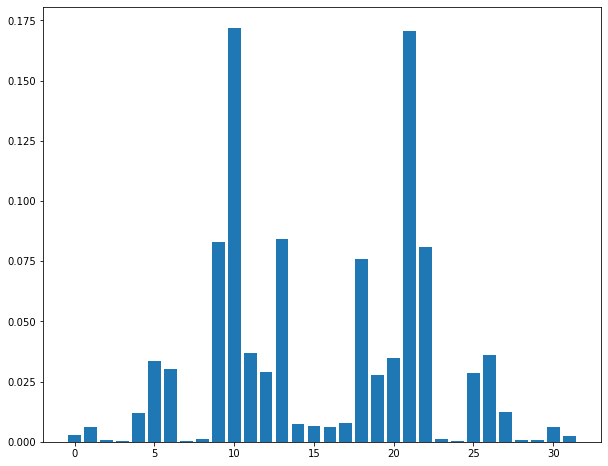

In [14]:
# plot
def plot_results(nums, freq):
    x = range(0, 2**num) # all possible numbers
    y = []
    for i in range(0, len(x)):
        if (i in nums):
            y.append(freq[nums.index(i)])
        else:
            y.append(0)

    plt.figure(figsize=(10,8))
    plt.bar(x, y)
    plt.show()
    return x,y

x,y = plot_results(nums, freq)

The two largest probabilites are for the numbers 10 and 21. This means that the solution to partitioning the 5 nodes for MaxCut corresponds to the 5-bit binary expansion of 10 and 21.  
They are:

In [15]:
print("Binary Expansion of 10: {}".format(np.binary_repr(10,num)))
print("Binary Expansion of 21: {}".format(np.binary_repr(21,num)))

Binary Expansion of 10: 01010
Binary Expansion of 21: 10101


They are the negation of each other, meaning that the following partition-  
Nodes {$0,2,4$} in one group and  
Nodes {$1,3$} in the other give the biggest cut, i.e. maximum number of edges crossing across the two sets, i.e. = 4.

Let us also define a function to calculate the weight corresponding to the solutions indicated by our algorithm:

In [16]:
def get_weight(solution):
    total_weight = 0.0
    # convert the number to binary
    sol = [n for n in list(np.binary_repr(solution, num))]
    grp_0 = []
    grp_1 = []
    for i in range(len(sol)):
        if sol[i] == '0':
            grp_0.append(i)
        else:
            grp_1.append(i)
    
    for i in grp_0:
        for j in grp_1:
            if G.has_edge(str(i),str(j)):
                total_weight += G.get_edge_data(str(i),str(j))['weight']
    
    return total_weight

In [17]:
print("Weight of solution 10 is: {}".format(get_weight(10)))
print("Weight of solution 21 is: {}".format(get_weight(21)))

Weight of solution 10 is: 4.0
Weight of solution 21 is: 4.0


The following function is a driver function just to combine all the steps together so that we can simply pass the input graph into it, we can see the plot at the end.

In [18]:
# driver function to run the entire algorithm with inputs G as input
# the argument 'count' is to return that many most probable solutions

def driver(G, count=5):
    init_params = [float(random.randint(0,314))/float(100) for i in range(0,2*p)]
    out = minimize(get_cost, x0 = init_params,
                   method = "COBYLA", options = {'maxiter':100})
    optimal_params = out['x']
    
    # optimal gammas and optimal betas
    opti_gammas = []
    opti_betas = []

    for i in range(0, len(optimal_params), 2):
        opti_gammas.append(optimal_params[i])
    for i in range(1, len(optimal_params), 2):
        opti_betas.append(optimal_params[i])
    
    qaoa_opti = make_circuit(num, opti_gammas, opti_betas, p)
    
    results = get_results(num, qaoa_opti, rep = reps)

    nums = []
    freq = []
    for i in range(0, len(results)):
        number = 0
        for j in range(0, len(results[i])):
            number += 2**(len(results[i])-j-1)*results[i][j]
        
        if (number in nums):
            freq[nums.index(number)] = freq[nums.index(number)] + 1
        else:
            nums.append(number)
            freq.append(1)

    # divide the frequency by the total number of samples
    freq = [f/reps for f in freq]
    x,y = plot_results(nums, freq)
    
    top = np.argsort(y,)[-count:]
    top = list(top[::-1])
    
    for i in range(count):
        print("The binary represention of",top[i],"is:",
              np.binary_repr(top[i], num),
              "| weight =",get_weight(top[i]))
    return qaoa_opti, top

Let's try a longer straight-line graph, still unweighted, with 9 nodes and 8 edges. We expect to see the same type of partition, i.e. 010101010 or 101010101, meaning the numbers 170 or 341 respectively.

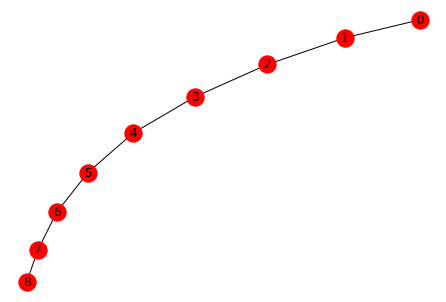

In [19]:
set_edges = [Edge(0,1), Edge(1,2), Edge(2,3), Edge(3,4),
             Edge(4,5), Edge(5,6), Edge(6,7), Edge(7,8)
            ]

G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight=edge.weight)
    
nx.draw(G, with_labels = True, node_color='r')

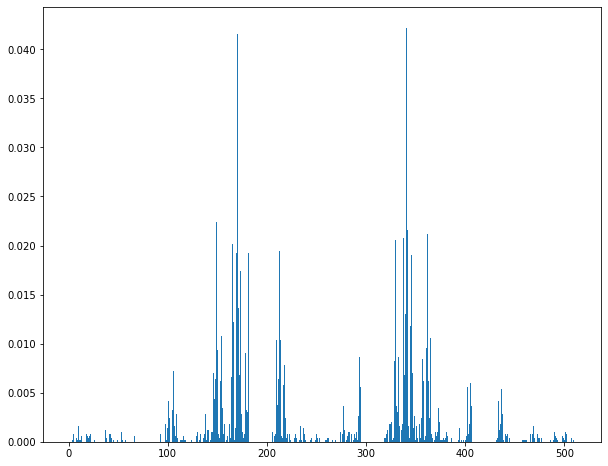

The binary represention of 341 is: 101010101 | weight = 8.0
The binary represention of 170 is: 010101010 | weight = 8.0
The binary represention of 149 is: 010010101 | weight = 7.0
The binary represention of 342 is: 101010110 | weight = 7.0
The binary represention of 362 is: 101101010 | weight = 7.0


In [20]:
num = G.number_of_nodes()
p = 1
reps = 5000
qaoa, top = driver(G)

As expected we have 170 and 341 as the most probable partitions.  
Group 1: {$0,2,4,6,8$}  
Group 2: {$1,3,5,7$}  

or vice versa.

Next we try a weighted graph. Notice we have already incorporated edge's weight term into the gamma parameter of the ZZ gate in the cost unitary, and in the cost function `get_cost`. And our class `Edge`'s  initialization function takes in an input for weight. Let's try a simple weighted graph, 4 nodes, 4 edges, with  
* weight 5.0 on the edge from 0 to 1,
* weight 1.0 on the edge from 1 to 2,
* weight 5.0 on the edge from 2 to 3,
* weight 5.0 on the edge from 3 to 0.  

We expect the partitions to be {$0, 2$} and {$1, 3$}, i.e. numbers 5 or 10

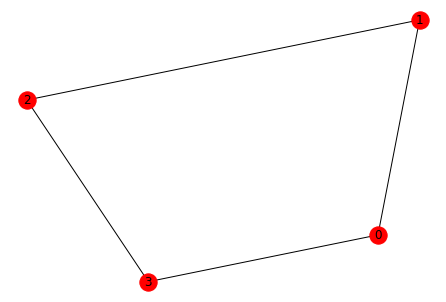

In [21]:
set_edges = [Edge(0,1,5.0), Edge(1,2,1.0), Edge(2,3,5.0), Edge(3,0,5.0)]
G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight = edge.weight)

nx.draw(G, with_labels = True, node_color = 'r')

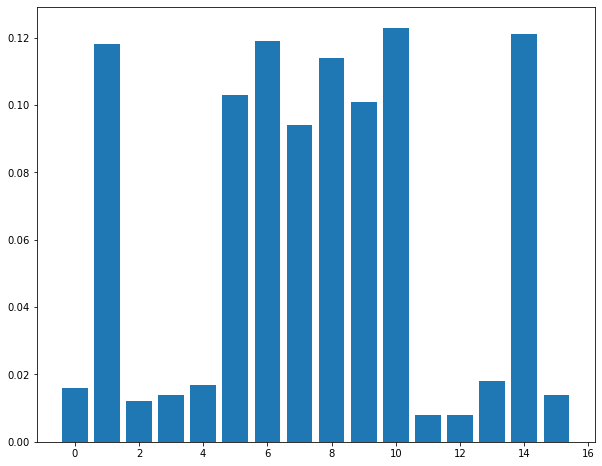

The binary represention of 10 is: 1010 | weight = 16.0
The binary represention of 14 is: 1110 | weight = 10.0
The binary represention of 6 is: 0110 | weight = 10.0
The binary represention of 1 is: 0001 | weight = 10.0
The binary represention of 8 is: 1000 | weight = 10.0


In [22]:
num = G.number_of_nodes()
p = 1
reps = 1000
qaoa = driver(G)

In various runs of the algorithm (`driver` function) we may encounter some undesirable solution states produced, as in the case above. That happens if the optimizing function gets stuck at some local minima, returning non-optimal parameters for $\normalsize \gamma$ and $\normalsize \beta$. Let's re-run the algorithm for the same graph as above.

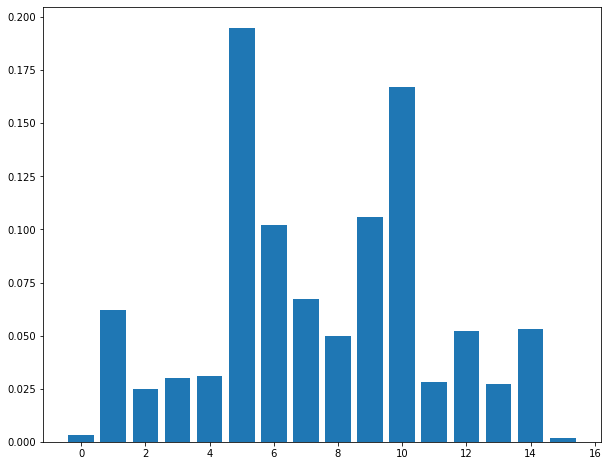

The binary represention of 5 is: 0101 | weight = 16.0
The binary represention of 10 is: 1010 | weight = 16.0
The binary represention of 9 is: 1001 | weight = 10.0
The binary represention of 6 is: 0110 | weight = 10.0
The binary represention of 7 is: 0111 | weight = 10.0


In [23]:
num = G.number_of_nodes()
p = 1
reps = 1000
qaoa = driver(G)

This result provides optimal solutions with high probability.

Let's run the algorithm on a scaled up, weighted graph example that can be found [here](http://eaton.math.rpi.edu/faculty/Mitchell/courses/matp6620/notesMATP6620/lecture11/11B_maxcut.pdf), (also displayed in the next cell). This pdf mentions 41 as a relatively high weight. Let's see if our QAOA can best that.   
This graph is more complex than the ones we have seen so far, with a greater range of weights and relatively higher number of nodes and edges. Fingers crossed!

WEIGHTED MAXCUT EXAMPLE


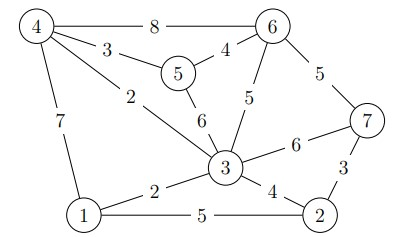

In [24]:
print("WEIGHTED MAXCUT EXAMPLE")
Image('w_maxcut_example.jpg',width=300,height=300)

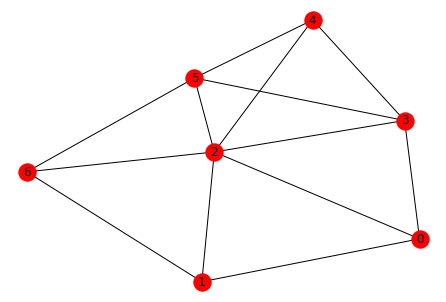

In [25]:
set_edges = [Edge(0,1,5.0), Edge(0,2,2.0), Edge(0,3,7.0), 
             Edge(1,2,4.0), Edge(1,6,3.0),
             Edge(2,3,2.0), Edge(2,4,6.0), Edge(2,5,5.0), Edge(2,6,6.0),
             Edge(3,4,3.0), Edge(3,5,8.0),
             Edge(4,5,4.0),
             Edge(5,6,5.0)
            ]

G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight = edge.weight)
    
nx.draw(G, with_labels=True, node_color='r')

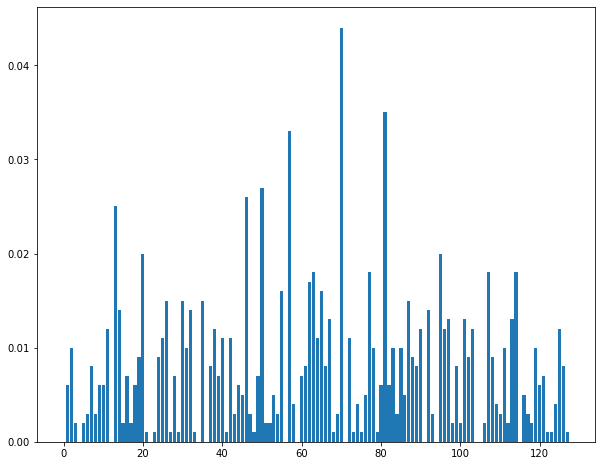

The binary represention of 70 is: 1000110 | weight = 41.0
The binary represention of 81 is: 1010001 | weight = 37.0
The binary represention of 57 is: 0111001 | weight = 41.0
The binary represention of 50 is: 0110010 | weight = 41.0
The binary represention of 46 is: 0101110 | weight = 37.0
The binary represention of 13 is: 0001101 | weight = 41.0
The binary represention of 95 is: 1011111 | weight = 12.0
The binary represention of 20 is: 0010100 | weight = 26.0
The binary represention of 77 is: 1001101 | weight = 41.0
The binary represention of 114 is: 1110010 | weight = 41.0


In [26]:
num = G.number_of_nodes()
p = 1
reps = 1000
qaoa, top = driver(G, count=10)

This run of the algorithm did as good as the source pdf linked above.  
What is the actual best solution? Classically, let's try to iterate over all the possible 128 7-bit strings and find what is the maximum weight possible.

In [27]:
maxcut_weight = -1

weights = [get_weight(i) for i in range(0,2**num)]
inds = [i for i in range(0,2**num) if get_weight(i) == max(weights)]
print("The maximum possible weight is", max(weights), "on the following indices:", inds)
print("The corresponding partitions:", [np.binary_repr(i,num) for i in inds])

The maximum possible weight is 47.0 on the following indices: [45, 82]
The corresponding partitions: ['0101101', '1010010']


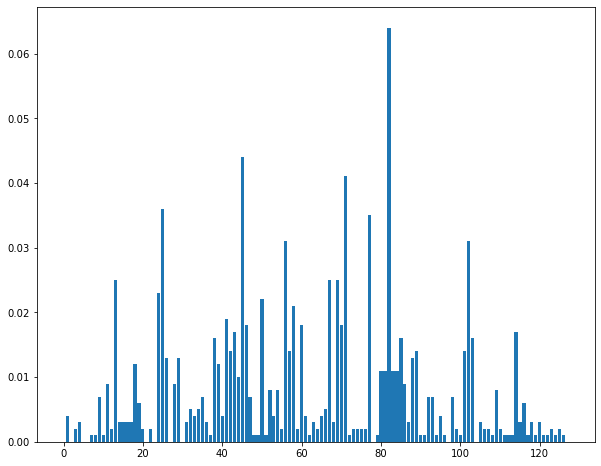

The binary represention of 82 is: 1010010 | weight = 47.0
The binary represention of 45 is: 0101101 | weight = 47.0
The binary represention of 71 is: 1000111 | weight = 45.0
The binary represention of 25 is: 0011001 | weight = 43.0
The binary represention of 77 is: 1001101 | weight = 41.0
The binary represention of 102 is: 1100110 | weight = 43.0
The binary represention of 56 is: 0111000 | weight = 45.0
The binary represention of 69 is: 1000101 | weight = 41.0
The binary represention of 67 is: 1000011 | weight = 40.0
The binary represention of 13 is: 0001101 | weight = 41.0


In [28]:
num = G.number_of_nodes()
p = 1
reps = 1000
qaoa, top = driver(G, count=10)

Well done QAOA!